In [1]:
# First, load the reticulate library and import the sagemaker Python module
library(reticulate)
sagemaker  <- import('sagemaker')

In [2]:
# Create an Amazon Simple Storage Service (S3) bucket for your data
# Note - The default_bucket function creates a unique Amazon S3 bucket with the following name: "sagemaker-<aws-region-name>-<aws account number>"
session <- sagemaker$Session()
bucket <- session$default_bucket()

In [3]:
# Specify the IAM role’s ARN to allow Amazon SageMaker to access the Amazon S3 bucket. You can use the same IAM role used to create this Notebook:
role_arn <- sagemaker$get_execution_role()

In [4]:
# loading required packages (since these are already available on sagemaker R kernel, no need to install them)
library(tidyverse)
library(modelr)

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [5]:
# loading airly sensor (sensor ids = 7201, 7599, 7803; instal ids = 41414, 41816, 42022) data
# for the period 15-08-2021 to 22-11-2021 (Only NO2, T and RH signals)
data_file <- 'data_airly.csv'
data_airly_all <- read_csv(file=data_file)#, col_types = cols("d", "d", "T", "c", "d", "d", "d"))
head(data_airly_all)

New names:
* `` -> ...1

Rows: 342156 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): status
dbl  (5): ...1, id, humidity, no2, temperature
dttm (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



...1,id,date,status,humidity,no2,temperature
<dbl>,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>
0,42022,2021-08-15 00:00:00,RAW,71.82511,297.1198,24.94795
1,42022,2021-08-15 00:05:00,RAW,72.20479,297.1906,24.84013
2,42022,2021-08-15 00:10:00,RAW,72.43551,297.3429,24.74854
3,42022,2021-08-15 00:15:00,RAW,72.64743,297.4239,24.66797
4,42022,2021-08-15 00:20:00,RAW,72.76068,297.6219,24.64623
5,42022,2021-08-15 00:25:00,RAW,73.05018,297.7695,24.57725


In [6]:
tail(data_airly_all)

...1,id,date,status,humidity,no2,temperature
<dbl>,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>
342150,41414,2021-11-21 23:35:00,FINAL,92.5,38.87538,5.055697
342151,41414,2021-11-21 23:40:00,FINAL,92.5,38.27329,5.057915
342152,41414,2021-11-21 23:45:00,FINAL,92.5,37.88230,5.038173
342153,41414,2021-11-21 23:50:00,FINAL,92.5,37.67418,5.020109
342154,41414,2021-11-21 23:55:00,FINAL,92.5,38.57907,4.988378
342155,41414,2021-11-22 00:00:00,FINAL,NA,NA,NA


In [57]:
# loading coloated reference senso (balcony analyser T200) data for the same period
data_file <- 'data_ref-LONDON.csv'
data_ref_all <- read_csv(file=data_file) %>% 
    mutate(Time = lubridate::force_tz(Time, "Europe/London")) %>%   # set time zone (for downloaded data) to local tzone
    mutate(date = lubridate::with_tz(Time, "UTC")) # convert time zone to UTC
head(data_ref_all)

Rows: 28512 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (3): NO, NO2, NOX
dttm (1): Time


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Time,NO,NO2,NOX,date
<dttm>,<dbl>,<dbl>,<dbl>,<dttm>
2021-08-15 01:00:00,4.43,21.3,25.8,2021-08-15 00:00:00
2021-08-15 01:05:00,3.14,20.8,24.0,2021-08-15 00:05:00
2021-08-15 01:10:00,2.85,20.6,23.4,2021-08-15 00:10:00
2021-08-15 01:15:00,3.60,20.8,24.4,2021-08-15 00:15:00
2021-08-15 01:20:00,4.04,21.2,25.2,2021-08-15 00:20:00
2021-08-15 01:25:00,4.53,22.0,26.5,2021-08-15 00:25:00


In [60]:
tail(data_ref_all)

Time,NO,NO2,NOX,date
<dttm>,<dbl>,<dbl>,<dbl>,<dttm>
2021-11-21 23:30:00,1.61,13.0,14.7,2021-11-21 23:30:00
2021-11-21 23:35:00,1.69,13.8,15.5,2021-11-21 23:35:00
2021-11-21 23:40:00,1.55,13.7,15.3,2021-11-21 23:40:00
2021-11-21 23:45:00,1.45,13.3,14.7,2021-11-21 23:45:00
2021-11-21 23:50:00,1.39,12.9,14.3,2021-11-21 23:50:00
2021-11-21 23:55:00,1.44,13.2,14.6,2021-11-21 23:55:00


In [61]:
data_airly_nested <- data_airly_all %>% 
  group_by(id) %>% 
  nest()

In [63]:
f_data_id <- function(df) {
    df %>% 
    select(date, status, no2) %>% 
    pivot_wider(names_from = status, values_from = c(no2))
}
data_airly_nested <- data_airly_nested %>% 
    mutate(data_id = map(data, f_data_id))

In [64]:
f_data_id_TRH <- function(df) {
    df %>% 
    filter(status=="RAW") %>% 
    select(date, temperature, humidity)
}
data_airly_nested <- data_airly_nested %>% 
    mutate(data_id_TRH = map(data, f_data_id_TRH))

In [66]:
# loading required packages (since these are NOT already available on sagemaker R kernel, we need to install them first)
install.packages("openair")
# library(openair)

also installing the dependencies ‘jpeg’, ‘latticeExtra’, ‘mapproj’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [67]:
f_base <- function(df) {
    df %>% 
    openair::timeAverage(avg.time = "60 min", statistic = "min", start.date = "2021-08-15 00:00:00")
}
# find baseline points (taking minimum of RAW over 1hr intervals)
data_airly_nested <- data_airly_nested %>% 
    mutate(data_id_base = map(data_id, f_base))

In [68]:
f_TRH_mean <- function(df) {
    df %>% 
    openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-08-15 00:00:00")
}
# find temperature points corresponding to baseline values (averaging over the same 1hr period)
data_airly_nested <- data_airly_nested %>% 
    mutate(data_id_TRH_mean = map(data_id_TRH, f_TRH_mean))

In [69]:
f_base_train <- function(df1, df2) {
    cbind(df1[,1:3], df2[,2:3])
}
data_airly_nested <- data_airly_nested %>% 
    mutate(base_train = map2(data_id_base, data_id_TRH_mean, f_base_train))

In [70]:
# building a polynomial model on baseline vs T
f_model_poly <- function(df){
  lm(RAW ~ poly(temperature, 2), data=df %>% na.exclude())
}
data_airly_nested <- data_airly_nested %>% 
  mutate(model_poly = map(base_train, f_model_poly))

In [71]:
f_comb <- function(df1, df2) {
    inner_join(df1, df2, by=c("date"="date"))
}
data_airly_nested <- data_airly_nested %>% 
  mutate(data_id_comb = map2(data_id, data_id_TRH, f_comb))

In [72]:
# add predictions of the model to the train data to find new baseline values 
f_add_preds <- function(df, model) {
    add_predictions(df, model, var = "baseline")
}
data_airly_nested <- data_airly_nested %>% 
  mutate(data_id_comb = map2(data_id_comb, model_poly, f_add_preds))

In [73]:
data_airly_unnested  <- data_airly_nested %>% 
  select(id, data_id_comb) %>% 
  unnest(cols = c(data_id_comb))
head(data_airly_unnested)

id,date,RAW,AUX,PPB,FINAL,temperature,humidity,baseline
<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42022,2021-08-15 00:00:00,297.1198,291.0501,26.00640,47.91067,24.94795,71.82511,292.7546
42022,2021-08-15 00:05:00,297.1906,290.9707,26.64045,49.09779,24.84013,72.20479,292.7909
42022,2021-08-15 00:10:00,297.3429,290.9539,27.30686,50.34218,24.74854,72.43551,292.8216
42022,2021-08-15 00:15:00,297.4239,290.9917,27.46796,50.65224,24.66797,72.64743,292.8484
42022,2021-08-15 00:20:00,297.6219,291.0800,27.83964,51.33843,24.64623,72.76068,292.8556
42022,2021-08-15 00:25:00,297.7695,291.0375,28.59472,52.74053,24.57725,73.05018,292.8785


In [74]:
data_airly_unnested$date[nrow(data_airly_unnested)] - data_airly_unnested$date[1]

Time difference of 99 days

In [75]:
# split data into training; first 30 days (~30%), the rest for test (~70%)
data_airly_train <- data_airly_unnested %>%
  filter(date < "2021-09-15 00-00-00")

data_airly_test <- data_airly_unnested %>%
  filter(date >= "2021-09-15 00-00-00")

data_ref_train <- data_ref_all %>%
  filter(date < "2021-09-15 00-00-00")

data_ref_test <- data_ref_all %>%
  filter(date >= "2021-09-15 00-00-00")

In [76]:
# average data over 1hr to reduce data points for final modeling and to match reference station interval
f_mean <- function(df) {
  df %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-08-15 00:00:00")
}
data_airly_train_nested <- data_airly_train %>% 
  nest() %>% 
  mutate(data_mean = map(data, f_mean))

data_ref_train_1hr <- data_ref_train %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-08-15 00:00:00")

In [77]:
f_comb2 <- function(df) {
  inner_join(df, data_ref_train_1hr, by=c("date"="date"))
}
data_airly_train_nested <- data_airly_train_nested %>% 
  mutate(data_comb = map(data_mean, f_comb2))

In [78]:
# rebuild train dataset by combining airly and ref values
gas_train <- data_airly_train_nested %>% 
    unnest(data_comb) %>% 
    select(id, NO2, RAW, baseline, temperature) %>%
    na.exclude()

In [87]:
tail(gas_train)

id,NO2,RAW,baseline,temperature
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41414,39.24167,306.1810,299.0400,22.18185
41414,32.82500,305.3284,299.4563,20.82333
41414,36.47500,306.0587,299.6963,19.95598
41414,31.46667,304.7914,299.8923,19.19452
41414,27.08333,303.8894,300.0801,18.40225
41414,21.84167,302.7994,300.2260,17.74062


In [80]:
# average data over 1hr to reduce data points to match train set processing
data_airly_test_nested <- data_airly_test %>% 
  nest() %>% 
  mutate(data_mean = map(data, f_mean))

data_ref_test_1hr <- data_ref_test %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-08-15 00:00:00")

In [81]:
f_comb3 <- function(df) {
  inner_join(df, data_ref_test_1hr, by=c("date"="date"))
}
data_airly_test_nested <- data_airly_test_nested %>% 
  mutate(data_comb = map(data_mean, f_comb3))

In [82]:
# rebuild train dataset by combining airly and ref values
gas_test <- data_airly_test_nested %>% 
    unnest(data_comb) %>% 
    select(id, NO2, RAW, baseline, temperature) %>%
    na.exclude()

In [88]:
tail(gas_test)

id,NO2,RAW,baseline,temperature
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41414,15.93333,301.6151,301.0590,11.549618
41414,13.95000,301.2534,301.0985,10.739492
41414,12.63333,301.1706,301.1071,10.509275
41414,12.97500,301.2316,301.1131,10.294385
41414,12.29167,301.3449,301.1258,9.645684
41414,13.16667,301.2929,301.1230,9.845522


In [112]:
temp <- gas_train_nested %>% 
    filter(id==42022) %>% 
    unnest(data) %>% 
    ungroup() %>% 
    select(-id)

In [111]:
train_ids

[1] 42022 41816 41414

In [113]:
head(temp)

NO2,RAW,baseline,temperature
<dbl>,<dbl>,<dbl>,<dbl>
21.55833,297.4983,292.8679,24.60835
17.80000,296.7222,293.0888,23.92445
15.29167,296.2973,293.2589,23.37839
11.87417,295.6056,293.4264,22.81762
10.91667,295.7697,293.3731,22.99725
13.33333,295.5761,292.9524,24.34073


In [145]:
# function to save train and test data locally
save_data_locally <- function(ID, TRAIN, TEST) {
  
  dir.create(stringr::str_glue("data", ID, "train", .sep = "/"), recursive = TRUE)
  
  temp1 <- TRAIN %>% 
    filter(id==ID) %>% 
    unnest(data) %>% 
    ungroup() %>% 
    select(-id)
  
  write_csv(temp1, str_glue("data", ID, "train", "train.csv", .sep = "/"), col_names=FALSE)
    
  dir.create(stringr::str_glue("data", ID, "test", .sep = "/"), recursive = TRUE)
  
  temp2 <- TEST %>% 
    filter(id==ID) %>% 
    unnest(data) %>% 
    ungroup() %>% 
    select(-id)
  
  write_csv(temp2, str_glue("data", ID, "test", "test_plus.csv", .sep = "/"), col_names=FALSE)
  write_csv(temp2[-1], str_glue("data", ID, "test", "test.csv", .sep = "/"), col_names=FALSE)
}

In [148]:
gas_train_nested <- gas_train %>% nest()
gas_test_nested <- gas_test %>% nest()
train_ids <- gas_train_nested %>% 
  {unique(.$id)}
test_ids <- gas_test_nested %>% 
  {unique(.$id)}

In [147]:
ID = vector(mode="numeric", length = 0)
for (ID in train_ids) {
  save_data_locally(ID, gas_train_nested, gas_test_nested)
}

Warning message in dir.create(stringr::str_glue("data", ID, "train", .sep = "/"), :
“'data/42022/train' already exists”
Warning message in dir.create(stringr::str_glue("data", ID, "test", .sep = "/"), :
“'data/42022/test' already exists”
Warning message in dir.create(stringr::str_glue("data", ID, "train", .sep = "/"), :
“'data/41816/train' already exists”
Warning message in dir.create(stringr::str_glue("data", ID, "test", .sep = "/"), :
“'data/41816/test' already exists”
Warning message in dir.create(stringr::str_glue("data", ID, "train", .sep = "/"), :
“'data/41414/train' already exists”
Warning message in dir.create(stringr::str_glue("data", ID, "test", .sep = "/"), :
“'data/41414/test' already exists”


In [149]:
# Then, upload the csv file to the Amazon S3 default bucket into the data key:
train_inputs = vector(mode = "character", length = length(train_ids))

for (ID in train_ids) {

    train_input = session$upload_data(path=str_glue("data", ID, "train", "train.csv", .sep = "/"),
                                      bucket=bucket,
                                      key_prefix=str_glue("r_demo4/data", ID, "train", .sep="/"))
    
    train_inputs = c(train_inputs, train_input)
#     print("Raw training data uploaded to : ", train_input)
}

In [150]:
# Then, upload the csv file to the Amazon S3 default bucket into the data key:
test_inputs = vector(mode = "character", length = length(test_ids))

for (ID in test_ids) {

    test_input = session$upload_data(path=str_glue("data", ID, "test", "test.csv", .sep = "/"),
                                      bucket=bucket,
                                      key_prefix=str_glue("r_demo4/data", ID, "test", .sep="/"))
    
    test_inputs = c(test_inputs, test_input)
#     print("Raw training data uploaded to : ", train_input)
}

In [151]:
# Amazon SageMaker algorithms are available via a Docker container. 
# To train an linear model, specify the training containers in Amazon Elastic Container Registry (ECR) for the AWS Region. 
# We will use the latest version of the algorithm.
container <- sagemaker$image_uris$retrieve(framework='linear-learner',
                                          region=session$boto_region_name, 
                                          version='latest')
cat('Linear Container Image URL: ', container)

Linear Container Image URL:  644912444149.dkr.ecr.eu-west-2.amazonaws.com/linear-learner:1

In [337]:
training_jobs <- vector("character")
for (ID in train_ids) {
    # define the Amazon S3 input types for the Amazon SageMaker algorithm:
    s3_input = str_glue('s3:/', bucket, 'r_demo4', "data", ID, "train", "train.csv", .sep = "/")
    s3_train_input <- sagemaker$inputs$TrainingInput(s3_data=s3_input,
                                                content_type='text/csv')
    
    # Model artifacts and batch output
    s3_output <- str_glue('s3:/', bucket, 'r_demo4','output', ID, .sep = '/')
    
    # Estimator: define an Amazon SageMaker Estimator, which can train any supplied algorithm that has been containerized with Docker.
    estimator <- sagemaker$estimator$Estimator(image_uri = container,
                                           role = role_arn,
                                           train_instance_count = 1L,
                                           train_instance_type = 'ml.m5.4xlarge',
                                           output_path = s3_output,
                                           sagemaker_session = session)
    
    # specify the linear-learner hyperparameters for the estimator
    estimator$set_hyperparameters(predictor_type="regressor",
                             mini_batch_size=100L)
    
    # create a training (aka, fitting) job name
    job_name <- str_glue('sagemaker-r-linear', ID, format(Sys.time(), '%H-%M-%S'), .sep='-')
    training_jobs <- c(training_jobs, job_name)

    # Define the data channels for train (optional: and validation) datasets
    input_data <- list('train'=s3_train_input)
    
    #! takes a few minutes...you can set wait=FALSE to bypass this but...
    # BEWARE that you may exceed AWS limit if there are too many instances running -> set wait=TRUE to avoid issues
    # train the estimator (aka, fit!)
    estimator$fit(inputs=input_data, job_name=job_name, wait=TRUE)
    
    # create a model based on this training job
    session$create_model_from_job(training_job_name=job_name)
}

In [315]:
# model <- estimator$create_model()

In [317]:
# model$model_data

[1] "s3://sagemaker-eu-west-2-870953422121/r_demo4/output/41414/sagemaker-r-linear-41414-15-45-12/output/model.tar.gz"

In [202]:
# pipeline <- import('sagemaker.pipeline')

In [333]:
# session$create_model(name="41414-temp-best",
#                      role=role_arn,
#                      container_defs=model$prepare_container_def(instance_type='ml.m4.xlarge'))

[1] "41414-temp-best"

In [334]:
# job_name

sagemaker-r-linear-41414-15-45-12

In [335]:
# session$create_model_from_job(job_name)

[1] "sagemaker-r-linear-41414-15-45-12"

In [326]:
# es_model = pipeline$PipelineModel(
#     name="41414-temp-test", 
#     role=role_arn, 
#     sagemaker_session=session,
#     models=list(model))

In [332]:
# es_model$deploy(initial_instance_count=1L, 
#                 instance_type='ml.m4.xlarge',
#                 )

In [338]:
training_jobs

[1] "sagemaker-r-linear-42022-17-10-57" "sagemaker-r-linear-41816-17-13-42"
[3] "sagemaker-r-linear-41414-17-17-27"

# Batch transform
In many situations, using a deployed model for making inference is not the best option, especially when the goal is not to make online real-time inference but to generate predictions from a trained model on a large dataset. In these situations, using Batch Transform may be more efficient and appropriate.

In [340]:
for (ID in test_ids) {
    # define s3 path for test data
    s3_test_url <- str_glue('s3:/', bucket, 'r_demo4', 'data', ID, 'test', 'test.csv', .sep='/')
    
    # Model artifacts and batch output
    s3_output <- str_glue('s3:/', bucket, 'r_demo4','output', ID, .sep = '/')
    
    # define a transformer
    transformer <- estimator$transformer(instance_count=1L,
                                        instance_type='ml.m5.4xlarge',
                                         model_name=grep(pattern = ID, training_jobs, value = TRUE),
#                                         strategy="MultiRecord",
                                        output_path=s3_output)
    
    #! takes a few minutes...you can set wait=FALSE to bypass this but...
    # BEWARE that you may exceed AWS limit if there are too many instances running -> set wait=TRUE to avoid issues
    # do the batch transform
    transformer$transform(s3_test_url,
                          content_type="text/csv",
    #                       split_type="Line",
                          wait=TRUE)
    
    # Download the files from S3 using S3Downloader to local SageMaker instance 'batch_output' folder
#     s3_input <- str_glue('s3:/', bucket, 'r_demo4','data', ID, "test", .sep = '/')
#     s3_output <- str_glue('s3:/', bucket, 'r_demo4','output', ID, .sep = '/')
#     sagemaker$s3$S3Downloader$download(s3_test_url,
#                           str_glue("batch_input", ID, .sep="/"))
     sagemaker$s3$S3Downloader$download(str_glue(s3_output,"test.csv.out",.sep = '/'),
                          str_glue("batch_output", ID, .sep="/"))
}

In [341]:
predictions = vector("list")
for (ID in test_ids) {    
    test_plus <- read_csv(file=str_glue("data", ID, "test", "test_plus.csv", .sep="/"),
                     col_names=c("NO2", "RAW", "baseline", "temperature"))
        
    prediction_id <- read_csv(file=str_glue("batch_output", ID, "test.csv.out", .sep="/"),
                       col_names='predicted_NO2')
    prediction_id$predicted_NO2 = extract_numeric(prediction_id$predicted_NO2)
    test_prediction <- cbind(id=rep(ID, times = length(prediction_id)), prediction_id, test_plus)
    predictions <- rbind(predictions, test_prediction)
}

Rows: 1378 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): NO2, RAW, baseline, temperature


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 1378 Columns: 1

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): predicted_NO2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

extract_numeric() is deprecated: please use readr::parse_number() instead

Rows: 1378 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): NO2, RAW, baseline, temperature


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this me

In [342]:
head(predictions)

,id,predicted_NO2,NO2,RAW,baseline,temperature
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,42022,21.04413,20.91667,297.1858,294.7527,17.10584
2,42022,18.85107,19.25000,296.6088,294.8363,16.60335
3,42022,16.28021,16.95000,295.9173,294.9126,16.11310
4,42022,16.14093,16.06667,295.9334,294.9767,15.67477
5,42022,16.43073,16.39167,296.0547,295.0157,15.39307
6,42022,17.92908,17.25000,296.4984,295.0182,15.37075


In [343]:
# define a function to calculate RMSE
rmse <- function(df){
    temp <- sqrt(mean((df$NO2-df$predicted_NO2)^2))
    temp <- round(temp, digits = 2)
    return(temp)
}

In [344]:
# calculate RMSE
test_rmse <- predictions %>% 
  group_by(id) %>% 
  group_modify(~data.frame(rmse(.x)))
# cat('RMSE for Batch Transform: ', round(gas_rmse, digits=2))

In [345]:
test_rmse

id,rmse..x.
<dbl>,<dbl>
41414,2.87
41816,3.31
42022,2.55


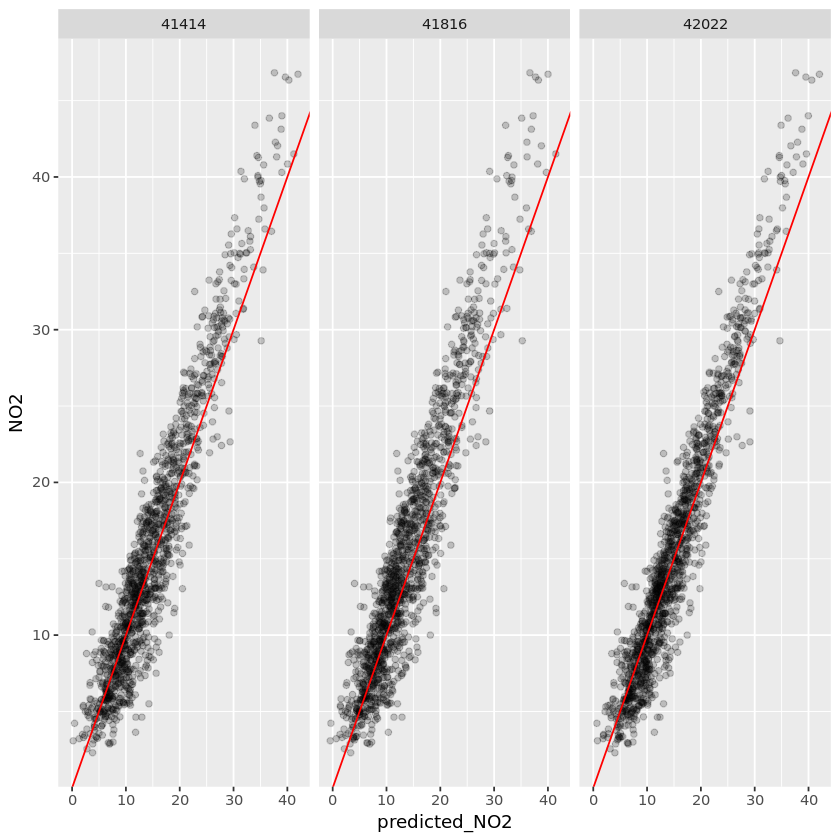

In [346]:
predictions %>% 
    ggplot(aes(x=predicted_NO2, y=NO2)) +
    geom_point(alpha=0.2) +
    geom_abline(slope=1, intercept=0, col="red") +
    facet_wrap(~id)

# Deployed model
Deploying the model as as endpoint is suitable for cases where you need to make online inference. Amazon SageMaker lets you deploy your model by providing an endpoint that consumers can invoke by a secure and simple API call using an HTTPS request.

In [191]:
boto3_r <- import('boto3')

In [192]:
sm <- boto3_r$client('sagemaker')

In [193]:
training_jobs

[1] "sagemaker-r-linear-42022-12-03-23" "sagemaker-r-linear-41816-12-06-38"
[3] "sagemaker-r-linear-41414-12-09-22"

In [194]:
response=sm$describe_training_job(TrainingJobName=job_name)

In [195]:
response

$TrainingJobName
[1] "sagemaker-r-linear-41414-12-09-22"

$TrainingJobArn
[1] "arn:aws:sagemaker:eu-west-2:870953422121:training-job/sagemaker-r-linear-41414-12-09-22"

$ModelArtifacts
$ModelArtifacts$S3ModelArtifacts
[1] "s3://sagemaker-eu-west-2-870953422121/r_demo4/output/41414/sagemaker-r-linear-41414-12-09-22/output/model.tar.gz"


$TrainingJobStatus
[1] "Completed"

$SecondaryStatus
[1] "Completed"

$HyperParameters
$HyperParameters$mini_batch_size
[1] "100"

$HyperParameters$predictor_type
[1] "regressor"


$AlgorithmSpecification
$AlgorithmSpecification$TrainingImage
[1] "644912444149.dkr.ecr.eu-west-2.amazonaws.com/linear-learner:1"

$AlgorithmSpecification$TrainingInputMode
[1] "File"

$AlgorithmSpecification$MetricDefinitions
$AlgorithmSpecification$MetricDefinitions[[1]]
$AlgorithmSpecification$MetricDefinitions[[1]]$Name
[1] "train:progress"

$AlgorithmSpecification$MetricDefinitions[[1]]$Regex
[1] "#progress_metric: host=\\S+, completed (\\S+) %"


$AlgorithmSpecification

In [196]:
s3_client = boto3_r$client('s3')

In [197]:
for (job_name in training_jobs) {
    response = sm$describe_training_job(TrainingJobName=job_name)
    url = response$ModelArtifacts$S3ModelArtifacts
    id = parse_number(str_extract(url, "/\\d+/"))
    sp = str_split(url, as.character(id))
    pre_plus = sp[[1]][1]; pre = str_split(pre_plus, "s3://")[[1]][2]
    mid = sp[[1]][2]; 
    pos = sp[[1]][3]
    # make a copy of the model artifacts from the original output of the training job to the place in
    # s3 where the multi model endpoint will dynamically load individual models
    s3_client$copy_object(Bucket=bucket, 
                          CopySource=str_c(pre, id, mid, id, pos),
                          Key=str_glue("r_demo4", "output", "multi-model", str_c(id, "_model.tar.gz"), .sep="/"))

}

In [198]:
bucket

[1] "sagemaker-eu-west-2-870953422121"

In [199]:
multidatamodel <- import('sagemaker.multidatamodel')

In [200]:
model_url  = str_glue("s3:/", bucket, "r_demo4/output/multi-model", .sep="/")

ll_multi_model = multidatamodel$MultiDataModel(
        name="model",
        model_data_prefix= model_url,
        image_uri=container,
        role=role_arn,
        sagemaker_session=session
    )

In [201]:
ll_multi_model

<sagemaker.multidatamodel.MultiDataModel>

In [202]:
pipeline <- import('sagemaker.pipeline')

In [230]:
sm_model = pipeline$PipelineModel(
    name="modelname2", 
    role=role_arn, 
    sagemaker_session=session,
    models=list(ll_multi_model))

In [232]:
#! takes a few minutes...
sm_model$deploy(initial_instance_count=1L, 
                instance_type='ml.m4.xlarge', 
                endpoint_name="endpointname2")

In [233]:
sm_model

<sagemaker.pipeline.PipelineModel>

In [234]:
#Create Predictor
predictor <- import('sagemaker.predictor')

In [235]:
csv_serializer = sagemaker$serializers$CSVSerializer(content_type='text/csv')

sm_predictor =  predictor$Predictor(
    endpoint_name="endpointname2",
    sagemaker_session=session,
    serializer=csv_serializer)

In [239]:
json <- reticulate::import("json")

In [272]:
predictions_ep = vector("list", length=0)
for (ID in test_ids) {
    
    test_plus <- read_csv(file = str_glue('data', ID, 'test', 'test_plus.csv', .sep='/'), col_names = NULL)
    test_sample <- as.matrix(test_plus[-1])
    preds_ep_id <- sm_predictor$predict(test_sample, target_model=str_c("/", ID, "_model.tar.gz"))
    temp <- json$loads(preds_ep_id)
    temp <- as_tibble(temp)
    temp <- sapply(temp, extract_numeric)
    preds_ep = cbind(temp, rep(ID, nrow(test_plus)), test_plus)
    colnames(preds_ep) = c("predicted_NO2", "id", "NO2", "RAW", "baseline", "temperature")
    predictions_ep = rbind(predictions_ep, preds_ep)
    
}

Rows: 1378 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): X1, X2, X3, X4


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

extract_numeric() is deprecated: please use readr::parse_number() instead

Rows: 1378 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): X1, X2, X3, X4


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

extract_numeric() is deprecated: please use readr::parse_number() instead

Rows: 1325 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): X1, X2, X3, X4


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set

In [273]:
head(predictions_ep)

,predicted_NO2,id,NO2,RAW,baseline,temperature
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,21.04413,42022,20.91667,297.1858,294.7527,17.10584
2,18.85107,42022,19.25000,296.6088,294.8363,16.60335
3,16.28021,42022,16.95000,295.9173,294.9126,16.11310
4,16.14099,42022,16.06667,295.9334,294.9767,15.67477
5,16.43073,42022,16.39167,296.0547,295.0157,15.39307
6,17.92908,42022,17.25000,296.4984,295.0182,15.37075


In [274]:
# calculate RMSE
test_rmse_ep <- predictions_ep %>% 
  group_by(id) %>% 
  group_modify(~data.frame(rmse(.x)))
# cat('RMSE for Batch Transform: ', round(gas_rmse, digits=2))
test_rmse_ep

id,rmse..x.
<dbl>,<dbl>
41414,2.87
41816,3.31
42022,2.55


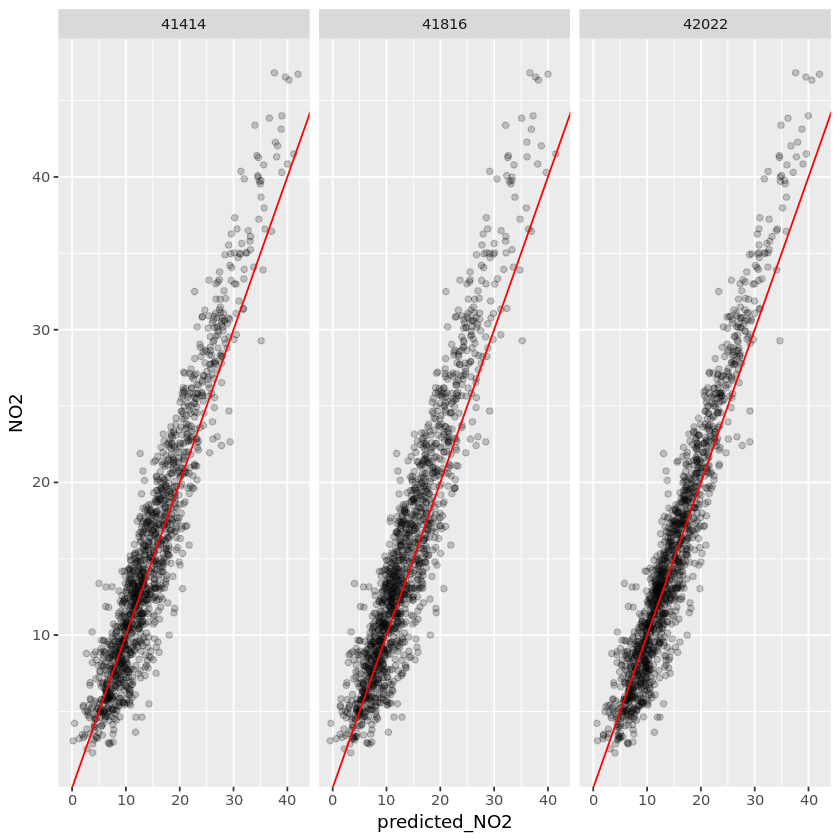

In [275]:
predictions_ep %>% 
    ggplot(aes(x=predicted_NO2, y=NO2)) +
    geom_point(alpha=0.2) +
    geom_abline(slope=1, intercept=0, col="red") +
    facet_wrap(~id)

# OPTIONAL

In [347]:
# When you’re done with the model, delete the endpoint to avoid incurring deployment costs:
sm_predictor$delete_endpoint()